<a href="https://www.kaggle.com/code/mdshakilhossain69/flex-match-438?scriptVersionId=256474448" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skindisnet-metadata/SkinDisNet_Metadata.csv
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (170)_01.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (305)_04.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (33)_05.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (293)_07.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (204)_03.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (137)_05.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (329)_02.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (210)_07.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (186)_05.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (203)_06.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (250)_06.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (166)_06.jpg
/kaggle/input/skindisnet-metadata/Augmented/Scabies (SC)/SC (279)_0

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from timm import create_model
from timm.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


SEEDS = [42, 1337, 2025]

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Fix global seed
GLOBAL_SEED = 12345
set_seed(GLOBAL_SEED)
print(f"Global seed fixed for dataset reproducibility: {GLOBAL_SEED}")
print("Per-run seeds for training:", SEEDS)
Using device: cuda
Global seed fixed for dataset reproducibility: 12345
Per-run seeds for training: [42, 1337, 2025]

SyntaxError: invalid syntax (271758240.py, line 38)

In [4]:
from pathlib import Path

data_dir = Path("/kaggle/input/skindisnet-metadata/Preprocessed")

classes = [d.name for d in data_dir.iterdir() if d.is_dir()]
print("Classes:", classes)
print("Number of classes:", len(classes))


Classes: ['Scabies (SC)', 'Seborrheic Dermatitis (SD)', 'Atopic Dermatitis (AD)', 'Eczema (EC)', 'Contact Dermatitis (CD)', 'Tinea Corporis (TC)']
Number of classes: 6


In [5]:
from pathlib import Path

# ---------------- Paths ----------------
DATA_DIR = Path("/kaggle/input/skindisnet-metadata/Preprocessed")
OUTPUT_DIR = Path("/kaggle/working/outputs_flexmatch")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- Config ----------------
IMG_SIZE = 224
BATCH_SIZE_LABELED = 16
BATCH_SIZE_UNLABELED = 32
NUM_WORKERS = 4

NUM_EPOCHS_PRIMARY = 50
NUM_EPOCHS_EXTENSION = 25
TARGET_VAL_ACC = 0.85

LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
EMA_DECAY = 0.999
CONSISTENCY_WEIGHT_MAX = 0.3
CONSISTENCY_RAMPUP_EPOCHS = 10
CONFIDENCE_THRESHOLD = 0.95

LABELED_FRACTION = 0.40
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1
TEST_FRAC = 0.1

# ---------------- Model ----------------
BACKBONE_NAME = "mobilenet_v3_large"
NUM_CLASSES = 6  # confirmed

CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = OUTPUT_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"DATA_DIR: {DATA_DIR}")
print(f"Backbone: {BACKBONE_NAME} | NUM_CLASSES: {NUM_CLASSES}")


DATA_DIR: /kaggle/input/skindisnet-metadata/Preprocessed
Backbone: mobilenet_v3_large | NUM_CLASSES: 6


In [7]:
# Cell 2: Stratified 80/10/10 train/val/test + labeled/unlabeled split
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff',
              '.JPG', '.JPEG', '.PNG', '.BMP', '.TIF', '.TIFF'}

all_paths, all_labels = [], []
class_to_idx = {}

for p in DATA_DIR.rglob("*"):
    if p.is_file() and p.suffix in valid_exts:
        cls_name = p.parent.name
        if cls_name not in class_to_idx:
            class_to_idx[cls_name] = len(class_to_idx)
        all_paths.append(p)
        all_labels.append(class_to_idx[cls_name])

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)
num_classes = len(class_to_idx)
print(f"Found {len(all_paths)} images across {num_classes} classes.")

# Split: train vs temp (val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - TRAIN_FRAC), random_state=42)
train_idx, temp_idx = next(sss1.split(all_paths, all_labels))
train_paths_all, train_labels_all = all_paths[train_idx], all_labels[train_idx]
temp_paths, temp_labels = all_paths[temp_idx], all_labels[temp_idx]

# Split temp -> val/test
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(temp_paths, temp_labels))
val_paths, val_labels = temp_paths[val_idx], temp_labels[val_idx]
test_paths, test_labels = temp_paths[test_idx], temp_labels[test_idx]

# Labeled/unlabeled split inside train
sss3 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - LABELED_FRACTION), random_state=42)
lab_idx, unlab_idx = next(sss3.split(train_paths_all, train_labels_all))
lab_paths, lab_labels = train_paths_all[lab_idx], train_labels_all[lab_idx]
unlab_paths = train_paths_all[unlab_idx]

# Save CSVs
splits_dir = OUTPUT_DIR / 'splits'
splits_dir.mkdir(parents=True, exist_ok=True)

pd.DataFrame({'path': train_paths_all.astype(str), 'label': train_labels_all}).to_csv(splits_dir / 'train_all.csv', index=False)
pd.DataFrame({'path': val_paths.astype(str), 'label': val_labels}).to_csv(splits_dir / 'val.csv', index=False)
pd.DataFrame({'path': test_paths.astype(str), 'label': test_labels}).to_csv(splits_dir / 'test.csv', index=False)
pd.DataFrame({'path': lab_paths.astype(str), 'label': lab_labels}).to_csv(splits_dir / 'train_labeled.csv', index=False)
pd.DataFrame({'path': unlab_paths.astype(str)}).to_csv(splits_dir / 'train_unlabeled.csv', index=False)

print("Splits CSVs saved at:", splits_dir.resolve())


Found 1710 images across 6 classes.
Splits CSVs saved at: /kaggle/working/outputs_flexmatch/splits


In [8]:
# Cell 3: Preprocessing & Augmentation
import cv2
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random

class ImagePreprocessor:
    def resize_with_aspect_ratio(self, image, target_size=IMG_SIZE):
        h, w = image.shape[:2]
        if h > w:
            new_h, new_w = target_size, int(w * (target_size / h))
        else:
            new_w, new_h = target_size, int(h * (target_size / w))
        resized = cv2.resize(image, (new_w, new_h))
        top, bottom = (target_size - new_h) // 2, target_size - new_h - (target_size - new_h) // 2
        left, right = (target_size - new_w) // 2, target_size - new_w - (target_size - new_w) // 2
        return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])

    def apply_noise_reduction(self, image):
        return cv2.medianBlur(cv2.GaussianBlur(image, (5,5),0), 5)

    def enhance_contrast(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        lab = cv2.merge([l,a,b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    def normalize_illumination(self, image, gamma=1.2):
        norm = np.power(image/255.0, gamma)
        return np.uint8(norm*255)

    def pipeline(self, path):
        img = cv2.imread(path)
        img = self.resize_with_aspect_ratio(img)
        img = self.apply_noise_reduction(img)
        img = self.enhance_contrast(img)
        img = self.normalize_illumination(img)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

preprocessor = ImagePreprocessor()

# ---------------- Torchvision augmentations ----------------
# Weak augmentations (for validation / consistency)
weak_aug = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(p=0.5),  # subtle orientation variation
    T.RandomRotation(10),          # small rotation
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # mild color jitter
    T.ToTensor()
])
# Strong augmentations (for training)

strong_aug = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 2.0)),
    T.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random'),
    T.ToTensor()
])

In [9]:
# ===============================
# Cell 4: Dataset & DataLoader for FlexMatch
# ===============================
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

# --- FlexMatch Dataset ---
class FlexMatchDataset(Dataset):
    def __init__(self, paths, labels=None, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = str(self.paths[idx])
        if self.transform:
            img = self.transform(path)  # Preprocessing + augmentation pipeline
        else:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img

# --- Preprocess + Transform Wrappers ---
class PreprocessTransform:
    def __call__(self, path_or_image):
        if isinstance(path_or_image, str):
            img = cv2.imread(path_or_image)
            if img is None:
                raise RuntimeError(f"Image failed to load: {path_or_image}")
        else:
            img = path_or_image
        img = preprocessor.resize_with_aspect_ratio(img)
        img = preprocessor.apply_noise_reduction(img)
        img = preprocessor.enhance_contrast(img)
        img = preprocessor.normalize_illumination(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

# --- Compose Preprocessing + Augmentation ---
labeled_transform = T.Compose([
    PreprocessTransform(),
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(0.4,0.4,0.4,0.1),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    T.RandomPerspective(distortion_scale=0.2, p=0.5),
    T.RandomAffine(0, translate=(0.1,0.1)),
    T.ToTensor()
])

unlabeled_transform = T.Compose([
    PreprocessTransform(),
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(0.4,0.4,0.4,0.1),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    T.RandomPerspective(distortion_scale=0.2, p=0.5),
    T.RandomAffine(0, translate=(0.1,0.1)),
    T.ToTensor()
])

val_transform = T.Compose([
    PreprocessTransform(),
    T.ToPILImage(),
    T.ToTensor()
])

test_transform = T.Compose([
    PreprocessTransform(),
    T.ToPILImage(),
    T.ToTensor()
])

# --- Datasets ---
labeled_dataset = FlexMatchDataset(lab_paths, lab_labels, transform=labeled_transform)
unlabeled_dataset = FlexMatchDataset(unlab_paths, None, transform=unlabeled_transform)
val_dataset = FlexMatchDataset(val_paths, val_labels, transform=val_transform)
test_dataset = FlexMatchDataset(test_paths, test_labels, transform=test_transform)

# --- DataLoaders ---
labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE_LABELED, shuffle=True, num_workers=0, pin_memory=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE_UNLABELED, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_LABELED, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_LABELED, shuffle=False, num_workers=0, pin_memory=True)

print(f"Labeled samples: {len(labeled_dataset)} | Unlabeled samples: {len(unlabeled_dataset)}")
print(f"Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

Labeled samples: 547 | Unlabeled samples: 821
Validation samples: 171 | Test samples: 171


In [12]:
# Cell 5: Model Setup, Freeze first 25% layers, AdamW optimizer
import torch.nn as nn
import torch
from torch.optim import AdamW
import torchvision.models as models

# Device setup (Kaggle GPU if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

def build_model(num_classes=NUM_CLASSES, pretrained=True):
    if pretrained:
        weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
    else:
        weights = None

    model = models.mobilenet_v3_large(weights=weights)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)
    return model

def freeze_layers(model, freeze_pct=0.25):
    params = list(model.parameters())
    total = len(params)
    freeze_count = int(total * freeze_pct)
    for i, p in enumerate(params):
        if i < freeze_count:
            p.requires_grad = False
    print(f"Frozen first {freeze_count} / {total} parameter tensors")
    return model

# Build and freeze
model = build_model(num_classes=NUM_CLASSES, pretrained=True).to(DEVICE)
model = freeze_layers(model, freeze_pct=0.25)

# Optimizer and loss
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()


Using device: cpu
Frozen first 43 / 174 parameter tensors


In [14]:
# Cell 6: Utilities for metrics and consistency weight
def compute_metrics(logits, targets):
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    targets = targets.cpu().numpy()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    return acc, f1

def get_current_consistency_weight(epoch):
    if epoch >= CONSISTENCY_RAMPUP_EPOCHS:
        return CONSISTENCY_WEIGHT_MAX
    else:
        return CONSISTENCY_WEIGHT_MAX * (epoch / CONSISTENCY_RAMPUP_EPOCHS)

In [15]:
# Cell 7: FlexMatch Training Loop
def train_flexmatch(model, labeled_loader, unlabeled_loader, val_loader, optimizer, criterion, num_epochs=NUM_EPOCHS_PRIMARY, target_acc=TARGET_VAL_ACC):
    train_loss_list, val_loss_list = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Iterators for labeled and unlabeled
        unlabeled_iter = iter(unlabeled_loader)
        for imgs_l, labels_l in tqdm(labeled_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs_l, labels_l = imgs_l.to(DEVICE), labels_l.to(DEVICE)

            # Labeled loss
            logits = model(imgs_l)
            loss_x = criterion(logits, labels_l)

            # Unlabeled batch
            try:
                imgs_u = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                imgs_u = next(unlabeled_iter)
            imgs_u = imgs_u.to(DEVICE)

            with torch.no_grad():
                logits_u = model(imgs_u)
                probs_u = torch.softmax(logits_u, dim=1)
                max_probs, pseudo_labels = torch.max(probs_u, dim=1)
                mask = max_probs.ge(CONFIDENCE_THRESHOLD).float()

            logits_u2 = model(imgs_u)
            loss_u = (F.cross_entropy(logits_u2, pseudo_labels, reduction='none') * mask).mean()

            # Total loss
            consistency_weight = get_current_consistency_weight(epoch)
            loss = loss_x + consistency_weight * loss_u

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs_l.size(0)

        epoch_loss = running_loss / len(labeled_loader.dataset)
        train_loss_list.append(epoch_loss)

        # Validation
        model.eval()
        val_running_loss, all_logits, all_labels = 0.0, [], []
        with torch.no_grad():
            for imgs_v, labels_v in val_loader:
                imgs_v, labels_v = imgs_v.to(DEVICE), labels_v.to(DEVICE)
                logits_v = model(imgs_v)
                loss_v = criterion(logits_v, labels_v)
                val_running_loss += loss_v.item() * imgs_v.size(0)
                all_logits.append(logits_v)
                all_labels.append(labels_v)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_loss_list.append(val_loss)
        all_logits = torch.cat(all_logits)
        all_labels = torch.cat(all_labels)
        val_acc, val_f1 = compute_metrics(all_logits, all_labels)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Save best checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), CHECKPOINT_DIR / f"best_model_epoch_{epoch+1}.pth")

    return train_loss_list, val_loss_list

In [18]:
# Utility: fix random seeds for reproducibility
import random
import numpy as np
import torch

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # can be True but may slow down
    torch.backends.cudnn.benchmark = True       # allows faster training
    print(f"Random seed set to {seed}")



--- Training with seed 42 ---
Random seed set to 42
Frozen first 43 / 174 parameter tensors


Epoch 1/50: 100%|██████████| 35/35 [02:28<00:00,  4.24s/it]


Epoch [1/50] Train Loss: 1.5171 | Val Loss: 1.3869 | Val Acc: 0.3801 | Val F1: 0.3224


Epoch 2/50: 100%|██████████| 35/35 [02:31<00:00,  4.34s/it]


Epoch [2/50] Train Loss: 1.2212 | Val Loss: 1.4435 | Val Acc: 0.4035 | Val F1: 0.2610


Epoch 3/50: 100%|██████████| 35/35 [02:33<00:00,  4.38s/it]


Epoch [3/50] Train Loss: 1.1475 | Val Loss: 1.3305 | Val Acc: 0.4971 | Val F1: 0.3965


Epoch 4/50: 100%|██████████| 35/35 [02:34<00:00,  4.42s/it]


Epoch [4/50] Train Loss: 1.0495 | Val Loss: 1.0910 | Val Acc: 0.5673 | Val F1: 0.4954


Epoch 5/50: 100%|██████████| 35/35 [02:33<00:00,  4.37s/it]


Epoch [5/50] Train Loss: 0.8548 | Val Loss: 1.4027 | Val Acc: 0.5263 | Val F1: 0.4574


Epoch 6/50: 100%|██████████| 35/35 [02:32<00:00,  4.37s/it]


Epoch [6/50] Train Loss: 0.7705 | Val Loss: 1.1408 | Val Acc: 0.6374 | Val F1: 0.5116


Epoch 7/50: 100%|██████████| 35/35 [02:27<00:00,  4.22s/it]


Epoch [7/50] Train Loss: 0.6665 | Val Loss: 1.0785 | Val Acc: 0.6550 | Val F1: 0.5839


Epoch 8/50: 100%|██████████| 35/35 [02:33<00:00,  4.39s/it]


Epoch [8/50] Train Loss: 0.6137 | Val Loss: 1.1405 | Val Acc: 0.6433 | Val F1: 0.5837


Epoch 9/50: 100%|██████████| 35/35 [02:33<00:00,  4.39s/it]


Epoch [9/50] Train Loss: 0.5691 | Val Loss: 1.3690 | Val Acc: 0.6316 | Val F1: 0.5385


Epoch 10/50: 100%|██████████| 35/35 [02:34<00:00,  4.42s/it]


Epoch [10/50] Train Loss: 0.4458 | Val Loss: 1.2260 | Val Acc: 0.6725 | Val F1: 0.6550


Epoch 11/50: 100%|██████████| 35/35 [02:31<00:00,  4.34s/it]


Epoch [11/50] Train Loss: 0.3884 | Val Loss: 1.1569 | Val Acc: 0.6667 | Val F1: 0.5910


Epoch 12/50: 100%|██████████| 35/35 [02:34<00:00,  4.42s/it]


Epoch [12/50] Train Loss: 0.3217 | Val Loss: 1.1111 | Val Acc: 0.6842 | Val F1: 0.6681


Epoch 13/50: 100%|██████████| 35/35 [02:33<00:00,  4.39s/it]


Epoch [13/50] Train Loss: 0.2812 | Val Loss: 1.3711 | Val Acc: 0.6784 | Val F1: 0.5902


Epoch 14/50: 100%|██████████| 35/35 [02:32<00:00,  4.36s/it]


Epoch [14/50] Train Loss: 0.2722 | Val Loss: 1.3741 | Val Acc: 0.6433 | Val F1: 0.6005


Epoch 15/50: 100%|██████████| 35/35 [02:32<00:00,  4.37s/it]


Epoch [15/50] Train Loss: 0.2333 | Val Loss: 1.2236 | Val Acc: 0.6901 | Val F1: 0.6523


Epoch 16/50: 100%|██████████| 35/35 [02:32<00:00,  4.35s/it]


Epoch [16/50] Train Loss: 0.2530 | Val Loss: 1.2156 | Val Acc: 0.6667 | Val F1: 0.6127


Epoch 17/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [17/50] Train Loss: 0.2513 | Val Loss: 1.2963 | Val Acc: 0.7193 | Val F1: 0.6869


Epoch 18/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [18/50] Train Loss: 0.2242 | Val Loss: 1.2972 | Val Acc: 0.6784 | Val F1: 0.6624


Epoch 19/50: 100%|██████████| 35/35 [02:31<00:00,  4.33s/it]


Epoch [19/50] Train Loss: 0.3039 | Val Loss: 1.5189 | Val Acc: 0.6433 | Val F1: 0.6123


Epoch 20/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [20/50] Train Loss: 0.1914 | Val Loss: 1.4105 | Val Acc: 0.6725 | Val F1: 0.6472


Epoch 21/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [21/50] Train Loss: 0.1729 | Val Loss: 1.1072 | Val Acc: 0.7076 | Val F1: 0.6909


Epoch 22/50: 100%|██████████| 35/35 [02:28<00:00,  4.25s/it]


Epoch [22/50] Train Loss: 0.1776 | Val Loss: 1.0502 | Val Acc: 0.7427 | Val F1: 0.7028


Epoch 23/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [23/50] Train Loss: 0.1295 | Val Loss: 1.2492 | Val Acc: 0.7485 | Val F1: 0.7312


Epoch 24/50: 100%|██████████| 35/35 [02:27<00:00,  4.22s/it]


Epoch [24/50] Train Loss: 0.1281 | Val Loss: 1.3839 | Val Acc: 0.7076 | Val F1: 0.6926


Epoch 25/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [25/50] Train Loss: 0.1943 | Val Loss: 1.1911 | Val Acc: 0.7427 | Val F1: 0.7052


Epoch 26/50: 100%|██████████| 35/35 [02:28<00:00,  4.23s/it]


Epoch [26/50] Train Loss: 0.1022 | Val Loss: 1.2401 | Val Acc: 0.7485 | Val F1: 0.7287


Epoch 27/50: 100%|██████████| 35/35 [02:31<00:00,  4.33s/it]


Epoch [27/50] Train Loss: 0.1795 | Val Loss: 1.4854 | Val Acc: 0.6725 | Val F1: 0.6666


Epoch 28/50: 100%|██████████| 35/35 [02:28<00:00,  4.25s/it]


Epoch [28/50] Train Loss: 0.1583 | Val Loss: 1.4074 | Val Acc: 0.7135 | Val F1: 0.6885


Epoch 29/50: 100%|██████████| 35/35 [02:31<00:00,  4.33s/it]


Epoch [29/50] Train Loss: 0.1831 | Val Loss: 1.2309 | Val Acc: 0.7310 | Val F1: 0.6999


Epoch 30/50: 100%|██████████| 35/35 [02:28<00:00,  4.23s/it]


Epoch [30/50] Train Loss: 0.1002 | Val Loss: 1.4321 | Val Acc: 0.7076 | Val F1: 0.6901


Epoch 31/50: 100%|██████████| 35/35 [02:32<00:00,  4.35s/it]


Epoch [31/50] Train Loss: 0.0864 | Val Loss: 1.4289 | Val Acc: 0.7076 | Val F1: 0.7031


Epoch 32/50: 100%|██████████| 35/35 [02:29<00:00,  4.29s/it]


Epoch [32/50] Train Loss: 0.1020 | Val Loss: 1.6798 | Val Acc: 0.6842 | Val F1: 0.6870


Epoch 33/50: 100%|██████████| 35/35 [02:31<00:00,  4.34s/it]


Epoch [33/50] Train Loss: 0.1284 | Val Loss: 1.6377 | Val Acc: 0.7193 | Val F1: 0.6942


Epoch 34/50: 100%|██████████| 35/35 [02:30<00:00,  4.29s/it]


Epoch [34/50] Train Loss: 0.1996 | Val Loss: 1.5389 | Val Acc: 0.6842 | Val F1: 0.6714


Epoch 35/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [35/50] Train Loss: 0.1699 | Val Loss: 1.6197 | Val Acc: 0.6725 | Val F1: 0.6563


Epoch 36/50: 100%|██████████| 35/35 [02:28<00:00,  4.25s/it]


Epoch [36/50] Train Loss: 0.0964 | Val Loss: 1.6742 | Val Acc: 0.6842 | Val F1: 0.6822


Epoch 37/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [37/50] Train Loss: 0.1232 | Val Loss: 1.6618 | Val Acc: 0.6842 | Val F1: 0.6686


Epoch 38/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [38/50] Train Loss: 0.0769 | Val Loss: 1.5191 | Val Acc: 0.7076 | Val F1: 0.6855


Epoch 39/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [39/50] Train Loss: 0.0843 | Val Loss: 1.6020 | Val Acc: 0.7193 | Val F1: 0.6965


Epoch 40/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [40/50] Train Loss: 0.0896 | Val Loss: 1.3187 | Val Acc: 0.7544 | Val F1: 0.7435


Epoch 41/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [41/50] Train Loss: 0.0561 | Val Loss: 1.3170 | Val Acc: 0.7544 | Val F1: 0.7206


Epoch 42/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [42/50] Train Loss: 0.1539 | Val Loss: 1.5349 | Val Acc: 0.7193 | Val F1: 0.6938


Epoch 43/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [43/50] Train Loss: 0.1070 | Val Loss: 1.6292 | Val Acc: 0.7251 | Val F1: 0.7009


Epoch 44/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [44/50] Train Loss: 0.1363 | Val Loss: 1.6667 | Val Acc: 0.7076 | Val F1: 0.6540


Epoch 45/50: 100%|██████████| 35/35 [02:30<00:00,  4.31s/it]


Epoch [45/50] Train Loss: 0.0846 | Val Loss: 1.4570 | Val Acc: 0.7368 | Val F1: 0.7122


Epoch 46/50: 100%|██████████| 35/35 [02:33<00:00,  4.40s/it]


Epoch [46/50] Train Loss: 0.0653 | Val Loss: 1.4412 | Val Acc: 0.7135 | Val F1: 0.7011


Epoch 47/50: 100%|██████████| 35/35 [02:30<00:00,  4.31s/it]


Epoch [47/50] Train Loss: 0.0581 | Val Loss: 1.6525 | Val Acc: 0.7251 | Val F1: 0.7124


Epoch 48/50: 100%|██████████| 35/35 [02:33<00:00,  4.40s/it]


Epoch [48/50] Train Loss: 0.1620 | Val Loss: 1.8190 | Val Acc: 0.6784 | Val F1: 0.6804


Epoch 49/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [49/50] Train Loss: 0.1274 | Val Loss: 1.5423 | Val Acc: 0.6901 | Val F1: 0.6626


Epoch 50/50: 100%|██████████| 35/35 [02:31<00:00,  4.34s/it]


Epoch [50/50] Train Loss: 0.1025 | Val Loss: 1.5705 | Val Acc: 0.7076 | Val F1: 0.6912
[Seed 42] Test Loss: 2.2990 | Test Acc: 0.6433 | Test F1 (macro): 0.5728


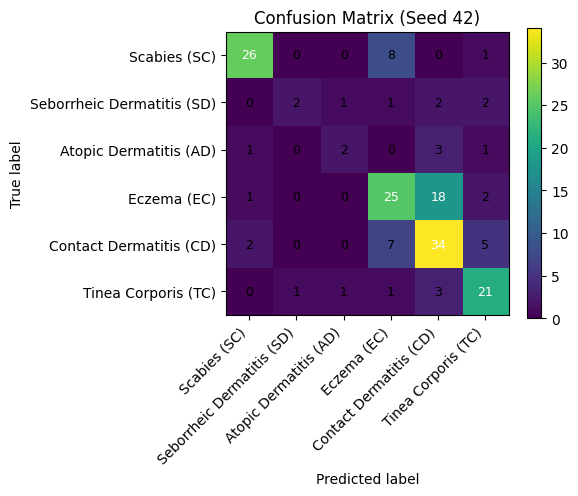

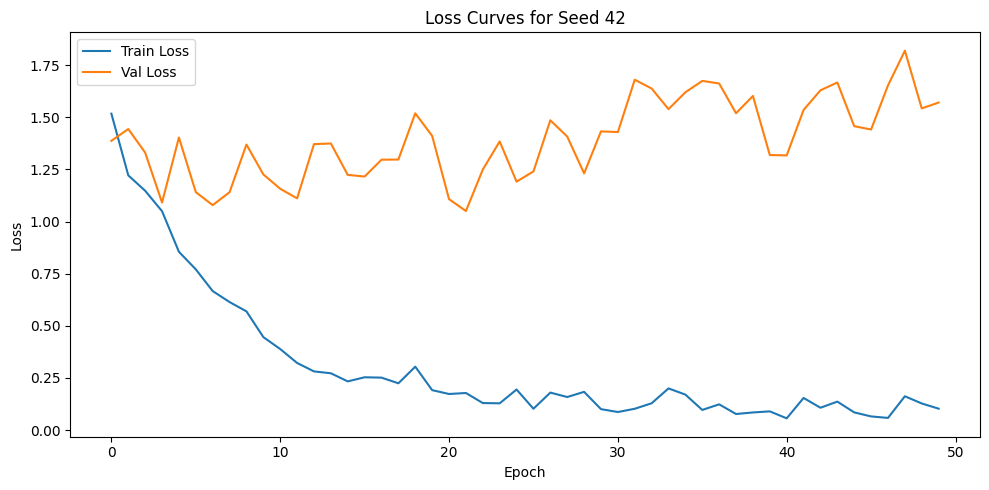


--- Training with seed 123 ---
Random seed set to 123
Frozen first 43 / 174 parameter tensors


Epoch 1/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [1/50] Train Loss: 1.4963 | Val Loss: 1.3271 | Val Acc: 0.4386 | Val F1: 0.3716


Epoch 2/50: 100%|██████████| 35/35 [02:37<00:00,  4.49s/it]


Epoch [2/50] Train Loss: 1.2250 | Val Loss: 1.2208 | Val Acc: 0.5439 | Val F1: 0.4172


Epoch 3/50: 100%|██████████| 35/35 [02:33<00:00,  4.39s/it]


Epoch [3/50] Train Loss: 1.0673 | Val Loss: 1.3509 | Val Acc: 0.5439 | Val F1: 0.4446


Epoch 4/50: 100%|██████████| 35/35 [02:32<00:00,  4.36s/it]


Epoch [4/50] Train Loss: 0.9234 | Val Loss: 1.3135 | Val Acc: 0.4971 | Val F1: 0.4114


Epoch 5/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [5/50] Train Loss: 0.8103 | Val Loss: 1.2521 | Val Acc: 0.6140 | Val F1: 0.5143


Epoch 6/50: 100%|██████████| 35/35 [02:33<00:00,  4.39s/it]


Epoch [6/50] Train Loss: 0.7153 | Val Loss: 1.1381 | Val Acc: 0.6608 | Val F1: 0.5629


Epoch 7/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [7/50] Train Loss: 0.7100 | Val Loss: 1.2876 | Val Acc: 0.6140 | Val F1: 0.5510


Epoch 8/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [8/50] Train Loss: 0.5648 | Val Loss: 1.0300 | Val Acc: 0.6842 | Val F1: 0.6130


Epoch 9/50: 100%|██████████| 35/35 [02:30<00:00,  4.31s/it]


Epoch [9/50] Train Loss: 0.4437 | Val Loss: 1.4312 | Val Acc: 0.6140 | Val F1: 0.5187


Epoch 10/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [10/50] Train Loss: 0.4577 | Val Loss: 1.2149 | Val Acc: 0.6433 | Val F1: 0.5716


Epoch 11/50: 100%|██████████| 35/35 [02:27<00:00,  4.22s/it]


Epoch [11/50] Train Loss: 0.3494 | Val Loss: 1.2174 | Val Acc: 0.6550 | Val F1: 0.6388


Epoch 12/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [12/50] Train Loss: 0.3188 | Val Loss: 1.2561 | Val Acc: 0.6784 | Val F1: 0.6723


Epoch 13/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [13/50] Train Loss: 0.2628 | Val Loss: 1.2081 | Val Acc: 0.7018 | Val F1: 0.6596


Epoch 14/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [14/50] Train Loss: 0.2898 | Val Loss: 1.5692 | Val Acc: 0.6491 | Val F1: 0.6568


Epoch 15/50: 100%|██████████| 35/35 [02:30<00:00,  4.31s/it]


Epoch [15/50] Train Loss: 0.2373 | Val Loss: 1.3328 | Val Acc: 0.6842 | Val F1: 0.6355


Epoch 16/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [16/50] Train Loss: 0.2825 | Val Loss: 1.4095 | Val Acc: 0.6959 | Val F1: 0.6652


Epoch 17/50: 100%|██████████| 35/35 [02:30<00:00,  4.29s/it]


Epoch [17/50] Train Loss: 0.2961 | Val Loss: 1.2672 | Val Acc: 0.6433 | Val F1: 0.6168


Epoch 18/50: 100%|██████████| 35/35 [02:30<00:00,  4.30s/it]


Epoch [18/50] Train Loss: 0.2169 | Val Loss: 1.1719 | Val Acc: 0.6725 | Val F1: 0.6591


Epoch 19/50: 100%|██████████| 35/35 [02:30<00:00,  4.31s/it]


Epoch [19/50] Train Loss: 0.1364 | Val Loss: 1.3078 | Val Acc: 0.7076 | Val F1: 0.6989


Epoch 20/50: 100%|██████████| 35/35 [02:30<00:00,  4.29s/it]


Epoch [20/50] Train Loss: 0.2079 | Val Loss: 1.5232 | Val Acc: 0.6316 | Val F1: 0.6293


Epoch 21/50: 100%|██████████| 35/35 [02:33<00:00,  4.39s/it]


Epoch [21/50] Train Loss: 0.1550 | Val Loss: 1.4370 | Val Acc: 0.6667 | Val F1: 0.5938


Epoch 22/50: 100%|██████████| 35/35 [02:33<00:00,  4.37s/it]


Epoch [22/50] Train Loss: 0.2169 | Val Loss: 1.3217 | Val Acc: 0.6725 | Val F1: 0.6524


Epoch 23/50: 100%|██████████| 35/35 [02:33<00:00,  4.38s/it]


Epoch [23/50] Train Loss: 0.1876 | Val Loss: 1.4891 | Val Acc: 0.6842 | Val F1: 0.6480


Epoch 24/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [24/50] Train Loss: 0.2247 | Val Loss: 1.1822 | Val Acc: 0.7251 | Val F1: 0.6624


Epoch 25/50: 100%|██████████| 35/35 [02:32<00:00,  4.37s/it]


Epoch [25/50] Train Loss: 0.1604 | Val Loss: 1.3932 | Val Acc: 0.6784 | Val F1: 0.6748


Epoch 26/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [26/50] Train Loss: 0.0965 | Val Loss: 1.5793 | Val Acc: 0.6725 | Val F1: 0.6609


Epoch 27/50: 100%|██████████| 35/35 [02:32<00:00,  4.35s/it]


Epoch [27/50] Train Loss: 0.0913 | Val Loss: 1.6196 | Val Acc: 0.7193 | Val F1: 0.6743


Epoch 28/50: 100%|██████████| 35/35 [02:28<00:00,  4.25s/it]


Epoch [28/50] Train Loss: 0.1045 | Val Loss: 1.5139 | Val Acc: 0.7310 | Val F1: 0.6926


Epoch 29/50: 100%|██████████| 35/35 [02:29<00:00,  4.28s/it]


Epoch [29/50] Train Loss: 0.1281 | Val Loss: 1.5086 | Val Acc: 0.7310 | Val F1: 0.7180


Epoch 30/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [30/50] Train Loss: 0.1490 | Val Loss: 1.7952 | Val Acc: 0.6901 | Val F1: 0.6797


Epoch 31/50: 100%|██████████| 35/35 [02:30<00:00,  4.31s/it]


Epoch [31/50] Train Loss: 0.1900 | Val Loss: 1.7222 | Val Acc: 0.6959 | Val F1: 0.6865


Epoch 32/50: 100%|██████████| 35/35 [02:27<00:00,  4.22s/it]


Epoch [32/50] Train Loss: 0.1217 | Val Loss: 1.5964 | Val Acc: 0.6959 | Val F1: 0.6752


Epoch 33/50: 100%|██████████| 35/35 [02:32<00:00,  4.35s/it]


Epoch [33/50] Train Loss: 0.1664 | Val Loss: 1.6641 | Val Acc: 0.7368 | Val F1: 0.7038


Epoch 34/50: 100%|██████████| 35/35 [02:30<00:00,  4.29s/it]


Epoch [34/50] Train Loss: 0.0869 | Val Loss: 1.5743 | Val Acc: 0.7135 | Val F1: 0.6903


Epoch 35/50: 100%|██████████| 35/35 [02:34<00:00,  4.42s/it]


Epoch [35/50] Train Loss: 0.1187 | Val Loss: 1.5678 | Val Acc: 0.6842 | Val F1: 0.6947


Epoch 36/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [36/50] Train Loss: 0.1239 | Val Loss: 1.6326 | Val Acc: 0.6667 | Val F1: 0.6481


Epoch 37/50: 100%|██████████| 35/35 [02:32<00:00,  4.37s/it]


Epoch [37/50] Train Loss: 0.1153 | Val Loss: 1.6489 | Val Acc: 0.7018 | Val F1: 0.6808


Epoch 38/50: 100%|██████████| 35/35 [02:28<00:00,  4.24s/it]


Epoch [38/50] Train Loss: 0.1786 | Val Loss: 1.9429 | Val Acc: 0.7018 | Val F1: 0.6484


Epoch 39/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [39/50] Train Loss: 0.2166 | Val Loss: 1.7003 | Val Acc: 0.7193 | Val F1: 0.6725


Epoch 40/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [40/50] Train Loss: 0.1405 | Val Loss: 1.7049 | Val Acc: 0.6725 | Val F1: 0.6457


Epoch 41/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [41/50] Train Loss: 0.0905 | Val Loss: 1.9173 | Val Acc: 0.6959 | Val F1: 0.6851


Epoch 42/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [42/50] Train Loss: 0.0784 | Val Loss: 1.7855 | Val Acc: 0.7310 | Val F1: 0.7197


Epoch 43/50: 100%|██████████| 35/35 [02:28<00:00,  4.24s/it]


Epoch [43/50] Train Loss: 0.1040 | Val Loss: 2.0694 | Val Acc: 0.6784 | Val F1: 0.6745


Epoch 44/50: 100%|██████████| 35/35 [02:29<00:00,  4.28s/it]


Epoch [44/50] Train Loss: 0.0561 | Val Loss: 1.7834 | Val Acc: 0.6784 | Val F1: 0.6694


Epoch 45/50: 100%|██████████| 35/35 [02:29<00:00,  4.26s/it]


Epoch [45/50] Train Loss: 0.0808 | Val Loss: 1.8705 | Val Acc: 0.6842 | Val F1: 0.6721


Epoch 46/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [46/50] Train Loss: 0.0766 | Val Loss: 2.1357 | Val Acc: 0.6842 | Val F1: 0.6785


Epoch 47/50: 100%|██████████| 35/35 [02:30<00:00,  4.29s/it]


Epoch [47/50] Train Loss: 0.0781 | Val Loss: 1.6898 | Val Acc: 0.7018 | Val F1: 0.7172


Epoch 48/50: 100%|██████████| 35/35 [02:28<00:00,  4.25s/it]


Epoch [48/50] Train Loss: 0.0533 | Val Loss: 1.7327 | Val Acc: 0.7076 | Val F1: 0.6865


Epoch 49/50: 100%|██████████| 35/35 [02:27<00:00,  4.21s/it]


Epoch [49/50] Train Loss: 0.1177 | Val Loss: 1.7169 | Val Acc: 0.7018 | Val F1: 0.6842


Epoch 50/50: 100%|██████████| 35/35 [02:32<00:00,  4.36s/it]


Epoch [50/50] Train Loss: 0.0850 | Val Loss: 1.9287 | Val Acc: 0.6959 | Val F1: 0.6806
[Seed 123] Test Loss: 2.1809 | Test Acc: 0.6725 | Test F1 (macro): 0.6249


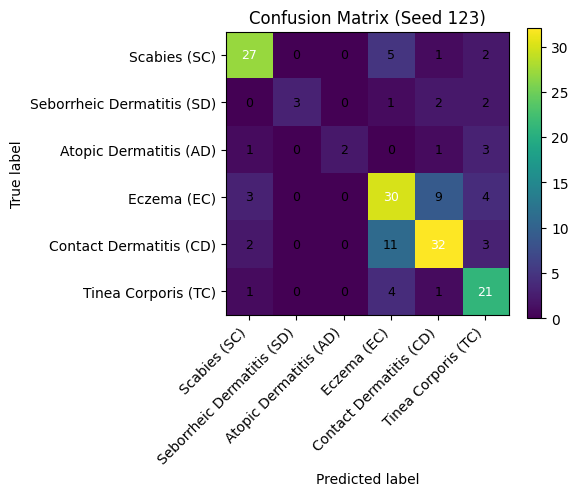

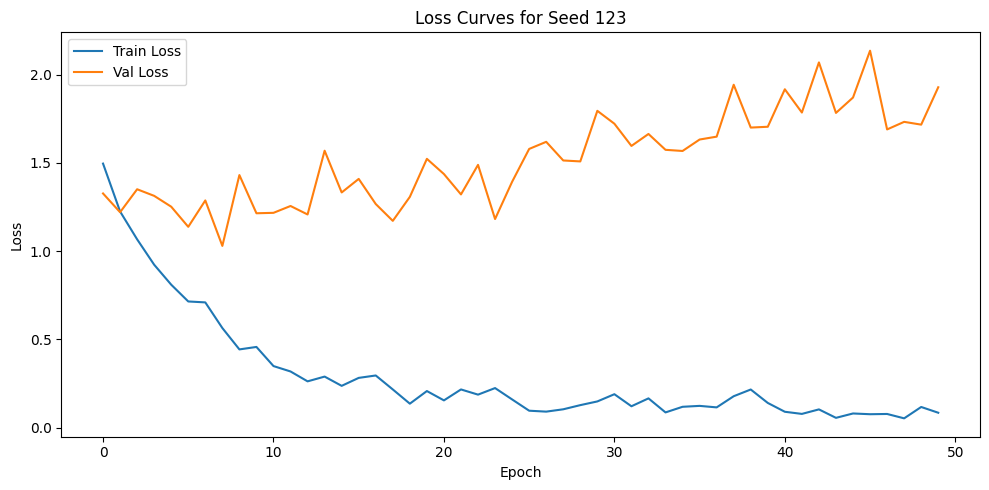


--- Training with seed 2025 ---
Random seed set to 2025
Frozen first 43 / 174 parameter tensors


Epoch 1/50: 100%|██████████| 35/35 [02:29<00:00,  4.27s/it]


Epoch [1/50] Train Loss: 1.5326 | Val Loss: 1.5137 | Val Acc: 0.3450 | Val F1: 0.2707


Epoch 2/50: 100%|██████████| 35/35 [02:32<00:00,  4.37s/it]


Epoch [2/50] Train Loss: 1.2404 | Val Loss: 1.3937 | Val Acc: 0.4444 | Val F1: 0.2910


Epoch 3/50: 100%|██████████| 35/35 [02:34<00:00,  4.42s/it]


Epoch [3/50] Train Loss: 1.1509 | Val Loss: 1.2838 | Val Acc: 0.5088 | Val F1: 0.4233


Epoch 4/50: 100%|██████████| 35/35 [02:35<00:00,  4.44s/it]


Epoch [4/50] Train Loss: 0.9956 | Val Loss: 1.2611 | Val Acc: 0.5439 | Val F1: 0.3793


Epoch 5/50: 100%|██████████| 35/35 [02:31<00:00,  4.32s/it]


Epoch [5/50] Train Loss: 0.8287 | Val Loss: 1.3289 | Val Acc: 0.5731 | Val F1: 0.5079


Epoch 6/50:  34%|███▍      | 12/35 [00:52<01:41,  4.42s/it]

In [ ]:
# Cell 8+9: Train across seeds + Test metrics (Acc/F1) + Confusion Matrices + Loss Curves
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---- Helper: evaluate on any loader ----
def evaluate_on_loader(model, loader, criterion):
    model.eval()
    all_logits, all_targets = [], []
    total_loss, total = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            total += y.size(0)
            all_logits.append(logits.cpu())
            all_targets.append(y.cpu())
    logits = torch.cat(all_logits) if all_logits else torch.empty(0)
    targets = torch.cat(all_targets) if all_targets else torch.empty(0, dtype=torch.long)
    if logits.numel() == 0:
        return np.nan, np.nan, np.nan, np.array([]), np.array([])
    preds = logits.argmax(1)
    acc = accuracy_score(targets.numpy(), preds.numpy())
    f1  = f1_score(targets.numpy(), preds.numpy(), average='macro')
    avg_loss = total_loss / max(total, 1)
    return avg_loss, acc, f1, preds.numpy(), targets.numpy()

# ---- Class names (from earlier Cell 2) ----
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(NUM_CLASSES)]

all_train_losses, all_val_losses = [], []
test_results = []

# Seeds to try
SEEDS = [42, 123, 2025]

for i, seed in enumerate(SEEDS):
    print(f"\n--- Training with seed {seed} ---")
    set_seed(seed)

    model = build_model(num_classes=NUM_CLASSES, pretrained=True).to(DEVICE)
    model = freeze_layers(model, freeze_pct=0.25)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # train_flexmatch must be defined earlier
    train_losses, val_losses = train_flexmatch(
        model, labeled_loader, unlabeled_loader, val_loader, optimizer, criterion
    )
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # ---- Test evaluation ----
    test_loss, test_acc, test_f1, test_preds, test_targets = evaluate_on_loader(model, test_loader, criterion)
    print(f"[Seed {seed}] Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test F1 (macro): {test_f1:.4f}")
    test_results.append({"seed": seed, "test_loss": test_loss, "test_acc": test_acc, "test_f1_macro": test_f1})

    # ---- Confusion Matrix (per seed) ----
    if test_preds.size and test_targets.size:
        cm = confusion_matrix(test_targets, test_preds, labels=list(range(NUM_CLASSES)))
        # Save CSV
        pd.DataFrame(cm, index=class_names, columns=class_names).to_csv(
            RESULTS_DIR / f"confusion_matrix_seed_{seed}.csv", index=True
        )
        # Plot & save figure
        plt.figure(figsize=(6,5))
        plt.imshow(cm, interpolation='nearest')
        plt.title(f"Confusion Matrix (Seed {seed})")
        plt.colorbar()
        tick_marks = np.arange(NUM_CLASSES)
        plt.xticks(tick_marks, class_names, rotation=45, ha="right")
        plt.yticks(tick_marks, class_names)
        thresh = cm.max() / 2.0 if cm.max() > 0 else 0
        for r in range(NUM_CLASSES):
            for c in range(NUM_CLASSES):
                plt.text(c, r, cm[r, c], ha="center", va="center",
                         color="white" if cm[r, c] > thresh else "black", fontsize=9)
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f"confusion_matrix_seed_{seed}.png", bbox_inches="tight")
        plt.show()
        plt.close()

    # ---- Plot & save loss curves for this seed ----
    plt.figure(figsize=(10,5))
    plt.plot(all_train_losses[i], label='Train Loss')
    plt.plot(all_val_losses[i], label='Val Loss')
    plt.title(f"Loss Curves for Seed {seed}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"loss_curves_seed_{seed}.png", bbox_inches="tight")
    plt.show()
    plt.close()

# ---- Save aggregated results ----
np.save(RESULTS_DIR / "train_losses.npy", np.array(all_train_losses, dtype=object))
np.save(RESULTS_DIR / "val_losses.npy",   np.array(all_val_losses, dtype=object))
pd.DataFrame(test_results).to_csv(RESULTS_DIR / "test_summary_per_seed.csv", index=False)

print("Training finished.")
print("Loss arrays saved to:", RESULTS_DIR / "train_losses.npy", "and", RESULTS_DIR / "val_losses.npy")
print("Per-seed test summary saved to:", RESULTS_DIR / "test_summary_per_seed.csv")
